# Measuring particularity and similarity in archaic Greek alphabets with NLP


In [2]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn import preprocessing
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [4]:
# tf-idf per document. Careful with tokenizer! Punctuation = new token! token_pattern = r'\S+'
vectorizer = TfidfVectorizer(token_pattern=r'\S+')


## Sanity check example

A simple example to test TF-IDF and cosine similarity on three sample sentences.

In [ ]:
ex_docs = ['The Cretan alphabet is a green alphabet', 'The Euboean alphabet is red', 'Cretan is a Greek dialect']

We parse the sentences with the TF-IDF vectorizer and show the results in a dataframe.

In [ ]:
ex_matrix = vectorizer.fit_transform(ex_docs)

In [ ]:
docs_df = pd.DataFrame(ex_matrix.toarray(),columns=vectorizer.get_feature_names())
docs_df

,a,alphabet,cretan,dialect,euboean,greek,green,is,red,the
0,0.327350,0.654700,0.327350,0.000000,0.000000,0.000000,0.430426,0.254217,0.000000,0.327350
1,0.000000,0.406192,0.000000,0.000000,0.534093,0.000000,0.000000,0.315444,0.534093,0.406192
2,0.406192,0.000000,0.406192,0.534093,0.000000,0.534093,0.000000,0.315444,0.000000,0.000000


We calculate the cosine similarity of each pair of sentences and put the results in a dataframe.

In [ ]:
ex_similarity = cosine_similarity(ex_matrix, ex_matrix)
ex_similarity

array([[1.        , 0.47909206, 0.34612509],
       [0.47909206, 1.        , 0.09950501],
       [0.34612509, 0.09950501, 1.        ]])

In [ ]:
sent_comp_df = pd.DataFrame(ex_similarity,columns=ex_docs, index=ex_docs)
sent_comp_df

,The Cretan alphabet is a green alphabet,The Euboean alphabet is red,Cretan is a Greek dialect
The Cretan alphabet is a green alphabet,1.000000,0.479092,0.346125
The Euboean alphabet is red,0.479092,1.000000,0.099505
Cretan is a Greek dialect,0.346125,0.099505,1.000000


In [ ]:
# all_pairs = sent_comp_df.unstack()
# all_pairs.index.rename(['Sent A', 'Sent B'], inplace=True)
# all_pairs = all_pairs.to_frame('cosine similarity').reset_index()

In [ ]:
# unique_pairs = all_pairs.drop_duplicates(subset=['cosine similarity'])
# unique_pairs[
#     (unique_pairs['cosine similarity'] < 1.0)
# ].sort_values(by=['cosine similarity'], ascending=False)

,Sent A,Sent B,cosine similarity
8,Cretan is a Greek dialect,Cretan is a Greek dialect,1.000000
1,The Cretan alphabet is a green alphabet,The Euboean alphabet is red,0.479092
2,The Cretan alphabet is a green alphabet,Cretan is a Greek dialect,0.346125
5,The Euboean alphabet is red,Cretan is a Greek dialect,0.099505


## Data pre-processing

We load the dataset, which in this case consists on a record of all Greek alphabetic inscriptions from the 8th and 7th centuries BC.

In [5]:
# read data
with open('dataset.json') as f:
  data = json.load(f)

The total number of inscriptions in the dataset:

In [6]:
# how many incriptions in the dataset:
len(data)

714

The fields found in each inscription: 

In [7]:
data[0].keys()

dict_keys(['Reference', 'Date', 'Origin', 'Lat', 'Long', 'Context', 'Material: object', 'Writing method', 'Writing direction', 'Content', 'a/a:', 'e', 'i/i:', 'o', 'u/u:/y/y:', '3:', '0:', 'e:', 'o:', 'm', 'n', 'l', 'r', 'w', 'h', 's', 'b', 'd', 'g', 'p', 't', 'k', 'ko/ku', 'ph', 'th', 'kh', 'ps', 'ks', 'dz', 'Division', 'Uncertain'])

We create a dictionary where each key represents an archaeological site or region and each value is a list with all grapheme-phoneme pairs recorded in the dataset for that site or region.

In [8]:
def build_documents(data):
  # build a dictionary where {origin: [list of tokens]}
  documents = {}
  
  checking_keys = ['a/a:', 'e', 'i/i:', 'o', 'u/u:/y/y:', '3:', '0:', 'e:', 'o:', 'm', 'n', 'l', 'r', 'w', 'h', 's', 'b', 'd', 'g', 'p', 't', 'k', 'ko/ku', 'ph', 'th', 'kh', 'ps', 'ks', 'dz', 'Division']

  # for each inscription, check origin. If not in dictionary, add except if the origin is uncertain
  for inscription in data:
    origin = inscription['Origin']
    if '?' not in origin:
      if origin not in documents.keys():
        documents[origin] = []
      
      # for each grapheme-phoneme pair, add to origin unless uncertain
      for key, values in inscription.items():
        if key in checking_keys:
          for value in values:
            if '?' not in value:
              token = key+value
              documents[origin].append(token)

    else:
      continue
      
  # we turn the lists into strings and eliminate keys with empty values before returning the dictionary
  documents = {k: ' '.join(v) for k, v in documents.items() if v}
  return documents


In [9]:
documents = build_documents(data)

We order them alphabetically and show them in a dataframe:

In [13]:
documents = sorted(documents.items())
documents_df = pd.DataFrame(documents, columns=['Origin', 'Text'])
documents_df

,Origin,Text
0,Achaia,a/a:1 e15 o43 m37 s38 d13 k33
1,Acrocorinth,a/a:1 e3 i/i:30* o43 0:43 e:15 n40 n40* l10 w1...
2,Aegina,e15 i/i:28 o43 n40 s32 p11 a/a:1 e15 m38 n40 l...
3,Aeolian Larisa,a/a:1 e15 e21 3:21 n40 d13 t57 a/a:1 e15 e21 3...
4,Aetos,a/a:1 e15 i/i:54 o43 n40 l34 w18 h23 s38 t57 p...
...,...,...
62,Thebes,a/a:1 e15 i/i:28 o43 u/u:/y/y:58 3:15 0:43 o:4...
63,Thera,i/i:31 0:43 n40 r52 kh33+23 a/a:1 e15 i/i:31 i...
64,Thermon,a/a:1 e15 i/i:31 o43 n40 l10 r52 w18 s38 d14 t...
65,Vari,a/a:1 e15 i/i:28 o:43 r52 d13 p47 kh41


## Particularity: TF-IDF 

We measure the relevance of grapheme-phoneme pairs for each site/region using TF-IDF.

In [14]:
matrix = vectorizer.fit_transform(documents_df['Text'])

In [15]:
matrix_df = pd.DataFrame(matrix.toarray(),columns=vectorizer.get_feature_names())
matrix_df

,0:43,0:44,0:45,0:64,3:15,3:21,3:23,3:3,a/a:1,a/a:2,a/a:46,b3,b4,b5,b6,b7,d13,d14,division12,division12*,division66,division67,division68,dz20,dz42,e15,e16,e21,e23,e3,e:,e:15,e:15+28,e:15+31,e:3,e:3+31,e:3+32,g10,g10*,g11,...,p48,p49,p50,p9,ph26,ph4,ph49,ph50+23,ph60,ph9,ps26+31,ps47+38,ps60+31*,ps61,ps9+38,r52,r53,s29,s30,s31,s31*,s32,s32*,s37,s38,s38*,s54,s55,s55*,t57,th25,th25+23,th26,th27,th44,u/u:/y/y:58,u/u:/y/y:59,w17,w18,w19
0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.272952,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.493829,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.281239,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.446314,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0.233851,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.120926,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.190386,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.336489,0.0,0.251516,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.183531,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.197732,0.465259,0.0,0.000000,0.0,0.142965,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.197732,0.0
2,0.000000,0.000000,0.0,0.0,0.165502,0.000000,0.000000,0.0,0.250787,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.131613,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.344535,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.100393,0.0,0.0,0.0,0.0,0.188626,0.400992,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0.000000,0.000000,0.0,0.0,0.000000,0.479388,0.000000,0.0,0.258422,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.155847,0.000000,0.0,0.0,0.239694,0.0,0.000000,0.0,0.00000,0.266268,0.0,0.662844,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.130736,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.203679,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0
4,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.243835,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.251238,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.000000,0.185035,0.000000,0.0,0.0,0.0,0.0,0.000000,0.230452,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.398704,0.000000,0.0,0.000000,0.0,0.144137,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.199352,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62,0.143765,0.000000,0.0,0.0,0.294363,0.000000,0.000000,0.0,0.148684,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.269002,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00000,0.153198,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.260406,0.225660,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.178560,0.0,0.0,0.0,0.0,0.167746,0.000000,0.198426,0.0,0.000000,0.000000,0.0,0.228126,0.0,0.087891,0.229804,0.000000,0.0,0.000000,0.0,0.217758,0.0,0.0,0.243120,0.0
63,0.026837,0.243051,0.0,0.0,0.082424,0.000000,0.207377,0.0,0.194285,0.0,0.0,0.0,0.0,0.0,0.160179,0.0,0.000000,0.218488,0.0,0.0,0.000000,0.0,0.074081,0.0,0.04861,0.157287,0.0

These are the 2 tokens with highest TF-IDF score per site/region:

In [13]:
pd.set_option("display.max_rows", None)
values_df = pd.DataFrame(documents_df['Origin'])
values_df['1token'] = matrix_df.columns[matrix_df.values.argsort(1)[:, -1]]
values_df['1score'] = matrix_df.apply(lambda row: sorted(row)[-1], axis=1)
values_df['2token'] = matrix_df.columns[matrix_df.values.argsort(1)[:, -2]]
values_df['2score'] = matrix_df.apply(lambda row: sorted(row)[-2], axis=1)
values_df

,Origin,1token,1score,2token,2score
0,Achaia,d13,0.493829,s38,0.446314
1,Acrocorinth,s38*,0.465259,n40*,0.423581
2,Aegina,s32,0.400992,l10,0.387612
3,Aeolian Larisa,e21,0.662844,3:21,0.479388
4,Aetos,i/i:54,0.469071,s38,0.398704
5,Afrati,i/i:30,0.368452,0:45,0.363895
6,Aigiale,s55,0.451990,p50,0.409863
7,Al Mina,b3,0.836674,e15,0.393030
8,Anaphe,0:44,0.466857,o44,0.434266
9,Argos,s38,0.324558,m37,0.318423


These results turned out not to be a good representation of the most idiosyncratic graphematic relationships per alphabet, as those sites with very low numbers of evidence gave higher scores to all of their features, irrespective of whether these are common across alphabets or not. That is what happens with Al Mina or Zagora.



In [ ]:
# how many tokens in Al Mina and Zagora as opposed to Athens or Penteskouphia
print(len(documents['Al Mina'].split()))
print(len(documents['Zagora'].split()))

print(len(documents['Penteskouphia'].split()))
print(len(documents['Athens'].split()))

Run the following cell if you wish to save the the results as an excel file:

In [14]:
values_df.to_excel('/results/most_characteristic_not_normalized.xlsx')

### Normalising the results

To get more plausible results we normalise the results of TF-IDF using the L1 norm, which will neutralise the broad differences in the length of these documents.

In [16]:
l1_matrix = preprocessing.normalize(matrix, norm='l1',axis=0)

In [17]:
l1_matrix_df = pd.DataFrame(l1_matrix.toarray(),columns=vectorizer.get_feature_names())
l1_values_df = pd.DataFrame(documents_df['Origin'])

Here is a table with the 10 most representative graphematic relationships per site/region after L1 normalisation.

In [21]:
value = 0
while value > -10:
  value -= 1
  token = 'token'+str(value)
  score = 'score'+str(value)
  l1_values_df[token] = l1_matrix_df.columns[l1_matrix_df.values.argsort(1)[:, value]]
  l1_values_df[score] = l1_matrix_df.apply(lambda row: sorted(row)[value], axis=1)

l1_values_df

,Origin,token-1,score-1,token-2,score-2,token-3,score-3,token-4,score-4,token-5,score-5,token-6,score-6,token-7,score-7,token-8,score-8,token-9,score-9,token-10,score-10
0,Achaia,d13,0.124456,m37,0.083892,s38,0.061849,k33,0.059216,o43,0.025529,e15,0.023033,a/a:1,0.021030,h22,0.000000,i/i:28,0.000000,h24,0.000000
1,Acrocorinth,s38*,1.000000,i/i:30*,0.648712,n40*,0.591263,e3,0.139095,e:15,0.096368,0:43,0.087999,w18,0.047290,d14,0.035881,p49,0.032871,l10,0.030005
2,Aegina,p11,1.000000,n40*,0.408737,s32,0.146500,s31*,0.065675,l10,0.062227,h23,0.051825,m38,0.051502,3:15,0.045303,k33,0.036272,e15,0.028217
3,Aeolian Larisa,e21,1.000000,3:21,0.366981,division66,0.359459,d13,0.039277,t57,0.025676,p49,0.023415,e15,0.021807,a/a:1,0.019910,n40,0.018391,i/i:28,0.010372
4,Aetos,i/i:54,1.000000,i/i:32,0.114467,h23,0.075582,ph60,0.065411,s38,0.055251,l34,0.052806,w18,0.047677,p49,0.033140,l10,0.030251,k33,0.026450
5,Afrati,0:45,1.000000,ks51+38,1.000000,p4,0.262086,i/i:30,0.177712,ph4,0.118896,ko/ku33,0.104146,i/i:30*,0.101476,3:23,0.089525,ks33+38,0.073693,l10,0.051630
6,Aigiale,s55,0.365114,p50,0.305578,g11,0.245508,3:15,0.079823,3:23,0.077457,m37,0.045271,d14,0.043706,u/u:/y/y:58,0.039237,t57,0.021952,i/i:28,0.017736
7,Al Mina,b3,0.388543,e15,0.032189,a/a:1,0.029389,h21,0.000000,i/i:29,0.000000,i/i:28,0.000000,h24,0.000000,h23,0.000000,h22,0.000000,w19,0.000000
8,Anaphe,o44,0.741583,0:44,0.657630,g10,0.209491,i/i:31,0.158821,p47,0.110516,th25,0.045350,ko/ku51,0.040201,d14,0.039547,u/u:/y/y:58,0.035503,t57,0.019863
9,Argos,division67,0.647989,division66,0.276095,l35,0.208299,g11,0.110279,g10,0.103995,3:15,0.071711,m37,0.061006,d13,0.060336,kh41,0.058296,s38,0.044976


Run the following cell if you wish to save the the results as an excel file:

In [23]:
l1_values_df.to_excel('/content/drive/MyDrive/Colab Notebooks/Data Thesis/most_characteristic_per_alph_l1.xlsx')

## Similarity: cosine similarity

Now we will calculate the cosine similarity of all pairs of alphabets using their non-normalised TF-IDF weights.

In [24]:
similarity = cosine_similarity(matrix, matrix)
l1_similarity = cosine_similarity(l1_matrix,l1_matrix)

In [26]:
def heatmap(data, row_labels, col_labels, ax=None,
            **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    # ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

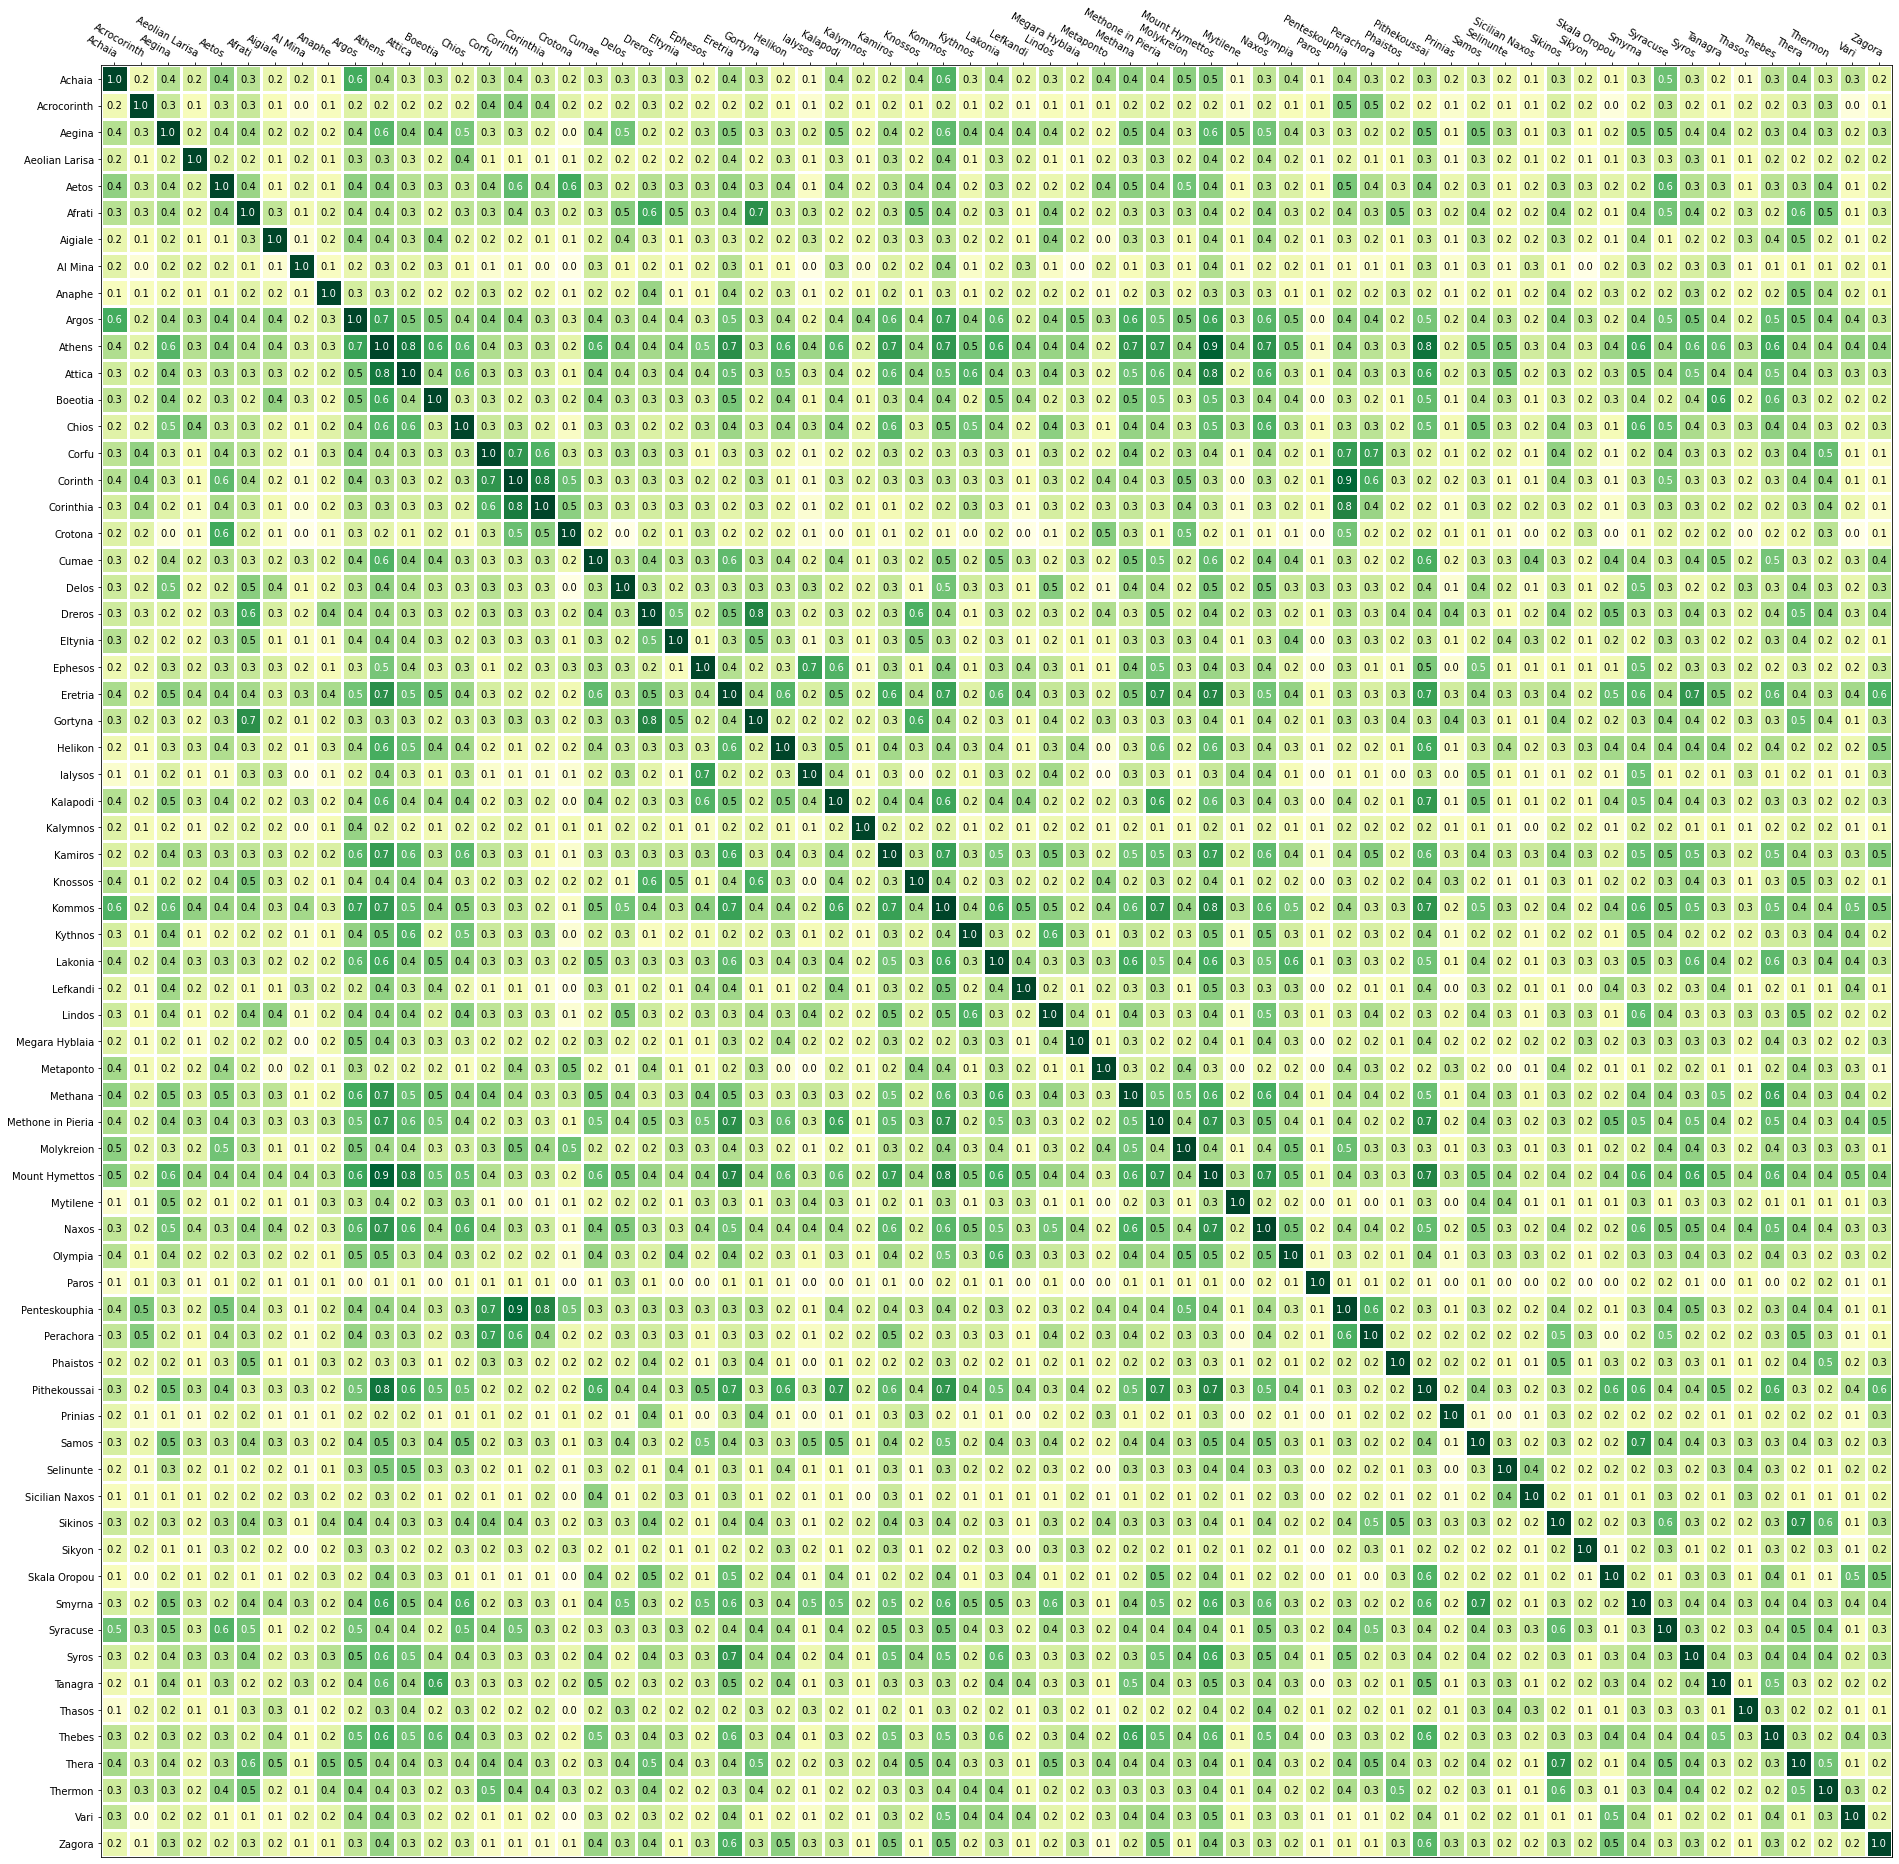

In [27]:
plt.rcParams['figure.figsize'] = [30, 26]
fig, ax = plt.subplots()

im = heatmap(similarity, documents_df['Origin'], documents_df['Origin'], ax=ax,
                   cmap="YlGn")
texts = annotate_heatmap(im, valfmt="{x:.1f}")

fig.tight_layout()
plt.show()

In [28]:
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Data Thesis/heatmap.png')

<Figure size 2160x1872 with 0 Axes>

Low scores not necessarily very different alphabets, but alphabets with low evidence (e.g. Paros).

In [29]:
similarity_df = pd.DataFrame(similarity, columns = documents_df['Origin'])

In [30]:
similarity_df.corr()

Origin,Achaia,Acrocorinth,Aegina,Aeolian Larisa,Aetos,Afrati,Aigiale,Al Mina,Anaphe,Argos,Athens,Attica,Boeotia,Chios,Corfu,Corinth,Corinthia,Crotona,Cumae,Delos,Dreros,Eltynia,Ephesos,Eretria,Gortyna,Helikon,Ialysos,Kalapodi,Kalymnos,Kamiros,Knossos,Kommos,Kythnos,Lakonia,Lefkandi,Lindos,Megara Hyblaia,Metaponto,Methana,Methone in Pieria,Molykreion,Mount Hymettos,Mytilene,Naxos,Olympia,Paros,Penteskouphia,Perachora,Phaistos,Pithekoussai,Prinias,Samos,Selinunte,Sicilian Naxos,Sikinos,Sikyon,Skala Oropou,Smyrna,Syracuse,Syros,Tanagra,Thasos,Thebes,Thera,Thermon,Vari,Zagora
Origin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Achaia,1.000000,0.160205,0.332699,0.281799,0.582461,0.328052,0.099141,0.197107,-0.038708,0.727046,0.302060,0.268187,0.304277,0.194499,0.367449,0.400451,0.272174,0.260369,0.235722,0.200940,0.211561,0.425835,0.057885,0.300154,0.292927,0.057962,-0.158199,0.290002,0.257668,0.313381,0.453070,0.571109,0.286764,0.421877,0.157785,0.223808,0.173017,0.549524,0.529505,0.350390,0.605990,0.397049,-0.145775,0.331551,0.441789,-0.072923,0.394938,0.357610,0.196884,0.260472,0.159585,0.171379,0.014100,-0.064237,0.323922,0.108822,0.029713,0.140525,0.596636,0.339082,0.143511,-0.173458,0.384571,0.415956,0.348653,0.323179,0.042653
Acrocorinth,0.160205,1.000000,0.091116,-0.091681,0.402395,0.330465,-0.013365,-0.217320,0.005530,0.104974,-0.114503,-0.051573,-0.037893,0.031177,0.696184,0.697152,0.638952,0.371488,-0.105512,0.155605,0.102340,0.180605,-0.027556,-0.198530,0.202143,-0.183028,-0.178172,-0.044328,0.114510,-0.027712,0.061369,-0.095883,0.014579,-0.038718,-0.265455,0.016782,-0.106231,0.193900,0.098027,-0.094346,0.264373,-0.124465,-0.234018,0.032224,-0.090456,0.131579,0.703403,0.686587,0.197576,-0.199239,-0.041314,-0.009000,-0.146961,-0.108131,0.331225,0.143136,-0.349823,-0.117815,0.411758,0.021706,-0.129239,0.036105,-0.020429,0.320507,0.443327,-0.307011,-0.256712
Aegina,0.332699,0.091116,1.000000,0.372733,0.194814,0.217092,0.301458,0.310136,0.058408,0.477806,0.693802,0.597118,0.541137,0.674677,0.094443,0.010456,-0.019575,-0.268422,0.433211,0.646285,-0.013441,0.121602,0.438301,0.521138,0.061608,0.417150,0.371589,0.598681,0.045100,0.564690,0.104976,0.703724,0.539338,0.551214,0.512062,0.457183,0.217104,-0.124924,0.578054,0.574964,0.137715,0.701054,0.548793,0.703275,0.510823,0.189343,0.063483,0.082500,0.043677,0.616891,-0.164143,0.674784,0.400716,0.011602,0.160781,-0.051953,0.184291,0.670090,0.416526,0.421575,0.464684,0.248850,0.450316,0.213607,0.172392,0.297091,0.365765
Aeolian Larisa,0.281799,-0.091681,0.372733,1.000000,0.160684,0.037717,0.085383,0.353730,0.084577,0.404628,0.488007,0.402409,0.286752,0.553584,-0.088924,-0.123135,-0.172990,-0.160889,0.313896,0.145177,0.001508,0.116611,0.299713,0.525160,-0.020300,0.378950,0.155473,0.473742,-0.002729,0.531385,0.132307,0.610543,0.153432,0.470227,0.370016,0.066089,0.041565,0.041143,0.353500,0.530776,0.169819,0.564058,0.303297,0.469337,0.388315,-0.091885,0.000670,-0.052706,-0.047594,0.483610,-0.093096,0.427767,0.211047,0.114910,0.042265,-0.086869,0.229917,0.392294,0.225912,0.508775,0.215073,0.071839,0.360877,0.017768,0.022528,0.330721,0.331304
Aetos,0.582461,0.402395,0.194814,0.160684,1.000000,0.371554,-0.087418,0.074850,-0.029949,0.442644,0.233497,0.218398,0.283662,0.174917,0.509963,0.673141,0.521133,0.737231,0.237194,0.031255,0.250206,0.382567,0.188611,0.228168,0.290676,0.191382,-0.177324,0.266741,0.163618,0.212391,0.429837,0.262806,0.060342,0.286286,-0.018972,-0.018753,0.089709,0.574439,0.443599,0.288798,0.680691,0.236179,-0.147366,0.178421,0.165998,-0.052585,0.656817,0.446291,0.235993,0.236665,0.123766,0.131202,-0.080401,-0.063752,0.359356,0.234938,-0.018777,0.008289,0.641139,0.349064,0.272110,-0.164315,0.289329,0.332411,0.457935,-0.046440,-0.004482
Afrati,0.328052,0.330465,0.217092,0.037717,0.371554,1.000000,0.271812,-0.054937,0.178549,0.214710,0.046303,0.131377,-0.037538,0.196390,0.360166,0.341782,0.247589,0.156703,0.027743,0.427303,0.665288,0.491716,0.114216,

In [37]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, min_val=0.6):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr_df = pd.DataFrame(au_corr, columns=['Score'])
    return au_corr_df.where(top_pairs['Score'] >= min_val, np.nan).dropna()

In [40]:
top_pairs = get_top_abs_correlations(similarity_df, min_val=0.8)
top_pairs

Score
Origin            Origin                     
Athens            Mount Hymettos     0.959211
Corinth           Penteskouphia      0.954639
                  Corinthia          0.916038
Athens            Pithekoussai       0.907368
Corinthia         Penteskouphia      0.904290
Eretria           Methone in Pieria  0.900297
Methone in Pieria Pithekoussai       0.899898
Athens            Attica             0.899682
Mount Hymettos    Pithekoussai       0.883448
Attica            Mount Hymettos     0.882679
Kommos            Mount Hymettos     0.880218
Eretria           Mount Hymettos     0.875251
Corfu             Corinth            0.868908
Methone in Pieria Mount Hymettos     0.868275
Corfu             Perachora          0.863878
Dreros            Gortyna            0.862636
Boeotia           Tanagra            0.859695
Kommos            Methone in Pieria  0.857589
Afrati            Gortyna            0.857025
Athens            Methone in Pieria  0.851867
Eretria           Pithekoussai       0.851395
Corfu             Penteskouphia      0.848458
Samos             Smyrna             0.845496
Sikinos           Thera              0.844121
Mount Hymettos    Naxos              0.829397
Kamiros           Mount Hymettos     0.828178
Athens            Eretria            0.825564
                  Naxos              0.825111
Kalapodi          Methone in Pieria  0.823811
                  Pithekoussai       0.819014
Ephesos           Ialysos            0.812743
Eretria           Syros              0.809036
Athens            Kamiros            0.806187
Corfu             Corinthia          0.805570
Methana           Thebes             0.805279
Kommos            Pithekoussai       0.805268
Athens            Kommos             0.803354
                  Lakonia            0.800992
Eretria           Kommos             0.800208

In [41]:
top_pairs.to_excel('/content/drive/MyDrive/Colab Notebooks/Data Thesis/top_alph_pairs.xlsx')